In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchode as to
from hydra import compose, initialize
from omegaconf import OmegaConf

from bioplnn.utils import AttrDict, initialize_model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [3]:
with initialize(version_base=None, config_path="config/", job_name="testing"):
    config = compose(
        config_name="config",
        overrides=["data=cifar10v1", "model=topo_sunny"],
    )
config = OmegaConf.to_container(config, resolve=True)
config = AttrDict(config)
sunny_root = "/om/user/sunnyd/dros-vision/"

In [4]:
# Load data
neuron_ids = pd.read_csv(sunny_root + "visual_neuron_ids.csv")
input_neuron_ids = pd.read_csv(sunny_root + "visual_column_assignment.csv")
column_data = torch.tensor(np.load(sunny_root + "moving_mnist_vision.npy"))
lookup = dict(zip(neuron_ids["root_id"].to_list(), neuron_ids.index))
input_indices = torch.tensor(input_neuron_ids["root_id"].map(lookup))
column_ids = torch.tensor(input_neuron_ids["column_ids"] - 1)

In [5]:
num_neurons = len(neuron_ids)
num_input_neurons = len(input_neuron_ids)

In [6]:
def save_connectivity():
    connectivity_hh = np.load(sunny_root + "visual_adj_matrix_20240711.npy")
    connectivity_hh = torch.tensor(connectivity_hh).to_sparse_coo().coalesce()

    # Load connectivity_ih
    indices_ih = torch.stack(
        (
            input_indices,
            torch.arange(input_neuron_ids.shape[0]),
        )
    )

    values_ih = torch.ones(indices_ih.shape[1])

    connectivity_ih = torch.sparse_coo_tensor(
        indices_ih,
        values_ih,
        (num_neurons, num_input_neurons),
        check_invariants=True,
    ).coalesce()

    # Save connectivity
    torch.save(connectivity_hh, config.model.rnn_kwargs.connectivity_hh)
    torch.save(connectivity_ih, config.model.rnn_kwargs.connectivity_ih)

    # Save input indices
    torch.save(input_indices, config.model.rnn_kwargs.input_indices)


# save_connectivity()

connectivity_hh = torch.load(
    config.model.rnn_kwargs.connectivity_hh, weights_only=True
)
connectivity_ih = torch.load(
    config.model.rnn_kwargs.connectivity_ih, weights_only=True
)
input_indices = torch.load(
    config.model.rnn_kwargs.input_indices, weights_only=True
)

In [7]:
config.model.rnn_kwargs.bias = False
rnn = initialize_model(config.data.dataset, config.model).rnn

In [8]:
connectivity_ih.values().shape

torch.Size([4751])

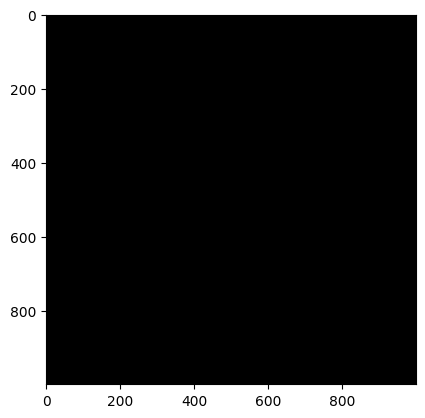

In [9]:
plt.imshow(
    connectivity_ih.to_dense()[:1000, :1000].detach().cpu().numpy(),
    cmap="gray",
)

In [10]:
def f(t, y, args):
    h = y.t()

    x = args["x"]
    bias = args["bias"]
    leak = args["leak"]
    T = args["tau"]

    x_t = x[:, int(t * 10), column_ids].t()

    h = 1 / T * (-h * leak + bias + rnn.hh(h) + 10 * rnn.ih(x_t))

    return h.t()


rnn.forward = f

In [11]:
y0 = torch.randn(len(neuron_ids)).unsqueeze(0).to(device)
t_eval = torch.linspace(0, 10, 20).unsqueeze(0).to(device)

term = to.ODETerm(rnn, with_args=True)
step_method = to.Dopri5(term=term)
step_size_controller = to.IntegralController(atol=1e-6, rtol=1e-3, term=term)
solver = to.AutoDiffAdjoint(step_method, step_size_controller).to(device)
# solver = torch.compile(solver)

In [12]:
# Solve ODE
problem = to.InitialValueProblem(y0=y0, t_eval=t_eval)
sol = solver.solve(
    problem,
    args={
        "x": column_data[:1].to(device),
        "bias": 0.1,
        "leak": 20.0,
        "tau": 10.0,
    },
)
ys = sol.ys.squeeze()

OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB. GPU 0 has a total capacity of 79.14 GiB of which 2.75 MiB is free. Including non-PyTorch memory, this process has 79.13 GiB memory in use. Of the allocated memory 78.51 GiB is allocated by PyTorch, and 129.96 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

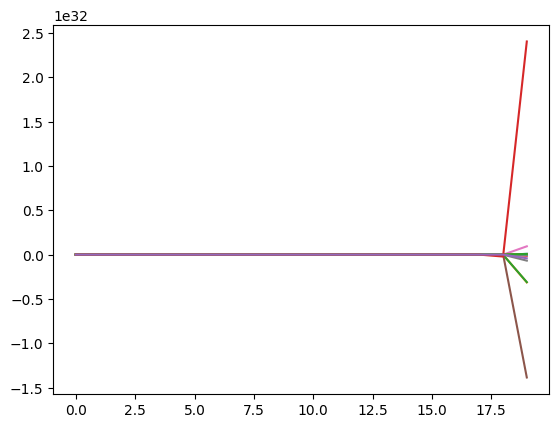

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ys[:, torch.randint(0, 47521, (25,))].detach().cpu().numpy())
plt.show()